Script based on https://albertoacerbi.github.io/IBM-cultevo/rogers-paradox.html

With added comments and some modifications by OM & AB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## A. Building the model

### A1. Initialise the population

#### Create a population of *N* individuals

*N*, the pop size, is a parameter whose value will be specified later. "learning" indicates the learning strategy of each individual.  
When the simulation starts, everyone is an individual learner, so learning = "individual", as opposed to "social".  

In [2]:
def initialise_population(N):
    """A1. Initialise the population and environment."""
    population = pd.DataFrame({
        "learning": ["individual"] * N,
        "behavior": [np.nan] * N,
        "fitness": [np.nan] * N,
    })
    return population

Let's assume that *N* = 1000 for now.

In [3]:
N = 1000
population = initialise_population(N)
population.head()

,learning,behavior,fitness
0,individual,NaN,NaN
1,individual,NaN,NaN
2,individual,NaN,NaN
3,individual,NaN,NaN
4,individual,NaN,NaN


### A2. Social learning learn from others

This part models the behavior of social learners: the individuals who have a "social" learning strategy.  
  
It only runs if the number of social learners in the population is not null.  
Since we start from a population of 100% individual learners, this won't run for the 1st generation.  
  
We extract the social learners from the population, and we make each one of them sample a random number of individuals from the previous population, and inherit their value for "behavior".

In [4]:
def social_learning(population, previous_population):
    mask_social = population["learning"] == "social"
    n_social = mask_social.sum()
    
    population.loc[mask_social, "behavior"] = np.random.choice(
        previous_population["behavior"].values,
        size=n_social,
        replace=True
    )
    return population

In [5]:
N = 1000

# We initalize the previous population with random value of behaviour
previous_population = initialise_population(N)
previous_population["behavior"] = np.random.choice([0, 1], size = N)

# We assign the current population random learning strategies
current_population = initialise_population(N)
current_population["learning"] = np.random.choice(["individual", "social"], size = N)

# We test the function
population = social_learning(current_population, previous_population)
population.head()

,learning,behavior,fitness
0,social,0.0,NaN
1,individual,NaN,NaN
2,social,0.0,NaN
3,social,1.0,NaN
4,individual,NaN,NaN


### A3. Individual learners learn to match their behavior to the environment  

This models the behavior of individual learners.  
  
These individuals match their behavior to the environment (*E*) with probability *p*.  
  
The behavior matches the environment when the corresponding integers are identical: in this case, learning is "correct".

In [6]:
def individual_learning(population, E, p):
    """A3. Individual learners try to match behavior to environment with probability p."""
    N = len(population)
    learn_correct = np.random.choice(
        [True, False],
        size = N,
        p = [p, 1 - p]
    )

    # This line picks all the individuals who are individual learners
    mask_individual = population["learning"] == "individual"

    # # This line picks all the individuals who are individual learners and has just been
    # tagged as "learn_correct = TRUE", and it matches their behavior to the environment.
    mask_correct = learn_correct & mask_individual
    population.loc[mask_correct, "behavior"] = E

    # This line does the opposite with individual learners who were tagged as 
    # learn_correct = FALSE. 
    # It makes them learn the wrong behavior, a behavior that is different from E,
    # and so does not match the environment.
    mask_incorrect = (~learn_correct) & mask_individual
    population.loc[mask_incorrect, "behavior"] = E - 1

    return population

The nature of the environment (*E*) is represented by an integer.  
The numeric value of the integer doesn't actually matter; we just use it to say whether two environments are the same or are different.  
Let's assume *E* = 0 and *p* = 0.5

In [7]:
E = 0
p = 0.5
N = 1000

population = initialise_population(N)
# We assign the current population random learning strategies
population["learning"] = np.random.choice(["individual", "social"], size = N)

individual_learning(population, E, p)

,learning,behavior,fitness
0,social,NaN,NaN
1,individual,-1.0,NaN
2,social,NaN,NaN
3,individual,0.0,NaN
4,social,NaN,NaN
...,...,...,...
995,individual,0.0,NaN
996,social,NaN,NaN
997,individual,-1.0,NaN
998,individual,0.0,NaN


### A4. Fitness is assigned to social and individual learners

Fitness is assigned to individuals in 3 steps:  
  1. Deal everyone the baseline *w* value  
  2. Grant or subtract benefit *b* to those whose behavior matches the environment  
  3. Subtract the costs of learning.  
  
We need a baseline for fitness: that is, a default value that is assigned to every individual before any change is made.  
  
Note : small *w* is the default value for fitness, not to be confounded with the population's average fitness, capital *W*.  
  
To compute fitness and adjust it to learning strategies, we need 3 more variables:  
  1. *b* : benefit of having a behaviour that match the environment *E*.  
  2. *c* : the cost of individual learning.  
  3. *s* : the cost of social learning.  

Learning cost (both *c* and *s*) depends on the possible gains (or losses) of accurate (or inaccurate) learning.  
  
Note : the value of *c* and *s* can be different.

In [8]:
def assign_fitness(population, E, w, b, c, s):
    """A4. Assign fitness to individuals based on behavior and learning strategy."""

    # Assign the default value for fitness
    population["fitness"] = w

    # Benefit or cost depending on match with environment
    mask_match = population["behavior"] == E
    mask_mismatch = population["behavior"] != E

    population.loc[mask_match, "fitness"] += b
    population.loc[mask_mismatch, "fitness"] -= b

    # Cost of individual learning
    mask_individual = population["learning"] == "individual"
    population.loc[mask_individual, "fitness"] -= b * c

    # Cost of social learning
    mask_social = population["learning"] == "social"
    population.loc[mask_social, "fitness"] -= b * s

    return population

*w* is hard-coded to 1, an arbitrary value.  
Let's assume that:  
- *b* = 0.5
- *c* = 0.8
- *s* = 0

Initialise the population with random value for learning and behaviour, and *w* for fitness.

In [ ]:
N = 1000
w = 1.0

population = initialise_population(N)
population["learning"] = np.random.choice(["individual", "social"], size = N)
population["fitness"] = [w] * N
population["behavior"] = np.random.choice([0, 1], size = N)
population.head()

,learning,behavior,fitness
0,individual,1,1
1,social,0,1
2,social,1,1
3,individual,0,1
4,social,0,1


Test the *assign_fitness* function.

In [10]:
E = 0
b = 0.5
c = 0.8
s = 0

assign_fitness(population, E, w, b, c, s)

,learning,behavior,fitness
0,individual,1,0.1
1,social,0,1.5
2,social,1,0.5
3,individual,0,1.1
4,social,0,1.5
...,...,...,...
995,individual,0,1.1
996,social,1,0.5
997,social,0,1.5
998,individual,0,1.1


Note: Multiplying c and s by b is a nicety, but the model works roughly the same without it.

### A5. Indidividuals reproduce according to their fitness

We know what we wanted to know about the current generation.  
It's time to wipe it out and get a new one.  
Which individuals will reproduce and spawn the next generation ?  
This depends on individual fitness values.  
Importantly, each individual's offspring will inherit its parent's social learning strategy, unless a mutation occurs.  
  
First, we compute the individual learners (IL) fitness compared to the overall population.  
  
Note : IL fitness = 0 if no one learns individually

In [11]:
def compute_IL_fitness(population):
    mask_individual = population["learning"] == "individual"
    total_fitness = population["fitness"].sum()

    if mask_individual.sum() > 0 and total_fitness > 0:
        IL_fitness = population.loc[mask_individual, "fitness"].sum() / total_fitness
    else:
        IL_fitness = 0.0

    return IL_fitness

Then, we draw the new learning strategies based on fitness.

In [12]:
def draw_learning_strategies(N, IL_fitness):
    return np.random.choice(
        ["individual", "social"],
        size = N,
        p = [IL_fitness, 1 - IL_fitness]
    )

Then, we initialise a new population with specific learning strategies.  
In the new generation, the proportion of individual learners will be proportional to their relative fitness in the previous generation.

In [13]:
def initialise_new_population(learning_new):
    N = len(learning_new)
    return pd.DataFrame({
        "learning": learning_new,
        "behavior": [np.nan] * N,
        "fitness": [np.nan] * N,
    })

Finally, we apply mutation to learning stratagies with probability *mu*.  
When a mutation occurs, it turns individual learners into social, and vice versa.

In [14]:
def mutate_learning(population, mu):
    mutation = np.random.choice([True, False], size = len(population), p = [mu, 1 - mu])
    
    # We save the previous population learning strategy
    learning_before = population["learning"].copy()

    mask_indiv_mut = (learning_before == "individual") & mutation
    mask_soc_mut = (learning_before == "social") & mutation

    population.loc[mask_indiv_mut, "learning"] = "social"
    population.loc[mask_soc_mut, "learning"] = "individual"

    return population

Now, we combine every function to make the reproduction function.

In [15]:
def reproduce(population, N, mu):

    # We save the previous population
    previous_population = population.copy()

    # Compute the fitness
    IL_fitness = compute_IL_fitness(previous_population)

    # Get the learning strategies
    learning_new = draw_learning_strategies(N, IL_fitness)

    # Initialise the new population
    population = initialise_new_population(learning_new)

    # Apply mutation to the new population
    population = mutate_learning(population, mu)

    return population, previous_population


We re-use some code from A4. to initialise our *previous_population*, then test the *reproduce* function.

In [ ]:
N = 1000
w = 1.0
E = 0
b = 0.5
c = 0.8
s = 0

previous_population = initialise_population(N)
previous_population["learning"] = np.random.choice(["individual", "social"], size = N)
previous_population["fitness"] = [w] * N
previous_population["behavior"] = np.random.choice([0, 1], size = N)
previous_population.head()
previous_population = assign_fitness(previous_population, E, w, b, c, s)
previous_population.head()

,learning,behavior,fitness
0,social,1,0.5
1,social,0,1.5
2,individual,0,1.1
3,individual,1,0.1
4,individual,0,1.1


Let's assume *mu* = 0.01.  

In [17]:
mu = 0.01

new_population, _ = reproduce(previous_population, N, mu)

new_population.head()

,learning,behavior,fitness
0,social,NaN,NaN
1,social,NaN,NaN
2,social,NaN,NaN
3,individual,NaN,NaN
4,individual,NaN,NaN


### A6. Change of environment

At each timestep / generation, the environment may change, with probability *u*.  
If it does, then the behavior that matched the environment in the previous generation no longer will: its fitness will be negative instead of positive.

In [18]:
def env_change(E, u):
    if np.random.rand() < u:
        E = E + 1
    return E

Let's assume *u* = 0.2 and test the function *env_change*

In [19]:
E = 0
u = 0.2

# Let's decide the number of test we will run and create a way to save data
n = 1000
data = []

# We run the function n time
for i in range(n):
    data.append(env_change(E, u))

# print the first 10 values of data
print(data[:10])

# Print the percentage of time the environment change. If the function runs correctly,
# this value should get closer to u we larger n
print(sum(data)/n * 100)

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
19.3


## B. Running the model

Now that we have all building blocks for the model, we can run it properly with a single function.

In [20]:
def rogers_model(N, t_max, r_max, 
                 w=1.0, b=0.5, c=0.9, s=0.0, mu=0.01, p=1.0, u=0.2):
    """
    Python translation of Rogers' model.

    Parameters mirror the R version:
    - N: population size
    - t_max: number of generations per run
    - r_max: number of runs
    - w: baseline fitness
    - b: benefit of matching environment (and cost of mismatch)
    - c: cost multiplier for individual learning
    - s: cost multiplier for social learning
    - mu: mutation probability of learning strategy
    - p: probability individual learners learn correctly
    - u: probability of environmental change per generation
    """

    # Initialise the environment
    E = 0

    # Parameter check to avoid negative fitness
    if b * (1 + c) > 1 or b * (1 + s) > 1:
        raise ValueError("Invalid parameter values: ensure b*(1+c) < 1 and b*(1+s) < 1")


    # Prepare output DataFrame
    generations = np.tile(np.arange(1, t_max + 1), r_max)
    runs = np.repeat(np.arange(1, r_max + 1), t_max)

    # Create output dataframe
    output = pd.DataFrame({
        "generation": generations,
        "run": runs.astype(str),
        "p_SL": np.nan,
        "W": np.nan,
    })

    # Main simulation
    for r in range(1, r_max + 1):
        population = initialise_population(N)
        previous_population = None

        for t in range(1, t_max + 1):
            # A2. Social learning
            if previous_population is not None: # first generation: nothing to copy
                population = social_learning(population, previous_population)

            # A3. Individual learning
            population = individual_learning(population, E, p)
            
            # A4. Fitness assignment
            population = assign_fitness(population, E, w, b, c, s)

            # Store summary stats
            mask = (output["generation"] == t) & (output["run"] == str(r))
            output.loc[mask, "p_SL"] = (population["learning"] == "social").mean()
            output.loc[mask, "W"] = population["fitness"].mean()

            # A5. Reproduction
            population, previous_population = reproduce(population, N, mu)

            # A6. Environment change
            E = env_change(E, u)

    return output

And now we can run the model !  
We will use Acerbi et. al.'s values at first :

In [ ]:
data_model = rogers_model(
    N=1000,
    t_max=200,
    r_max=10,
    w=1.0,
    b=0.5,
    c=0.9,
    s=0.0,
    mu=0.01,
    p=1.0,
    u=0.2
)

data_model.head()

,generation,run,p_SL,W
0,1,1,0.000,1.05000
1,2,1,0.015,1.05675
2,3,1,0.024,1.06080
3,4,1,0.039,1.06755
4,5,1,0.072,1.01040


Note : An explanation for every parameters can be found in the function description.

## C. Visualising results

### Plot of the proportion of social learners over time.

In [22]:
def plot_multiple_runs_p_SL(data_model):
    plt.figure(figsize=(10, 6))

    # Plot each run
    for run_id, df_run in data_model.groupby("run"):
        plt.plot(df_run["generation"], df_run["p_SL"], alpha=0.4, label=f"run {run_id}")

    # Plot mean across runs
    mean_p_SL = data_model.groupby("generation")["p_SL"].mean()
    plt.plot(mean_p_SL.index, mean_p_SL.values, color="black", linewidth=2, label="mean")

    plt.ylim(0, 1)
    plt.xlabel("generation")
    plt.ylabel("proportion of social learners")
    plt.title("Proportion of social learners over time")
    plt.tight_layout()
    plt.show()

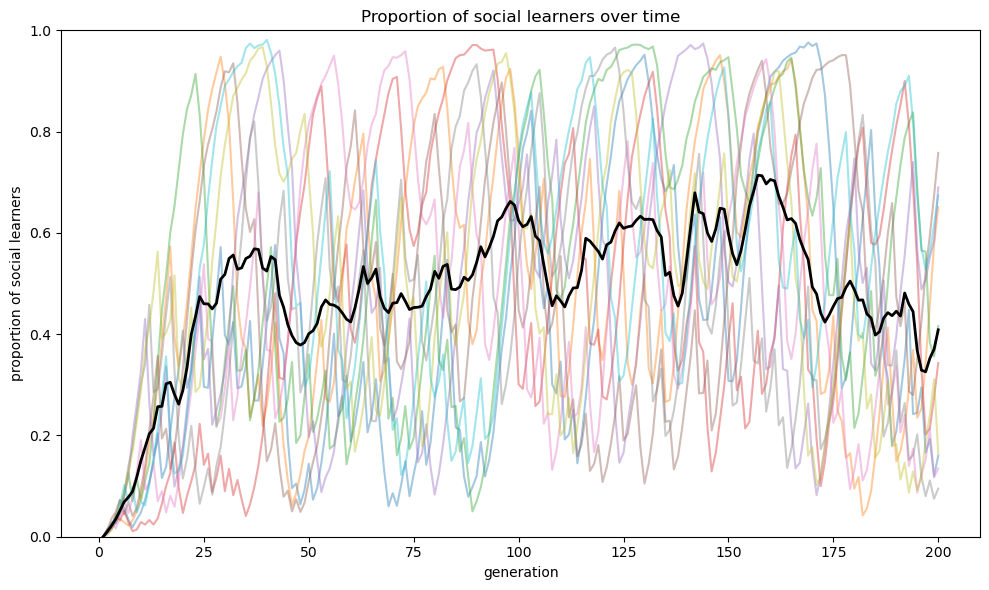

In [23]:
plot_multiple_runs_p_SL(data_model)

### Plot of the average fitness of the population over time.  
  
The dotted line correspond to the fitness of individual learning, equal to :  
$$
w + b * (2 * p - c - 1)
$$  
with :  
- *w* : baseline fitness value  
- *b* : benefit of matching the environment  
- *p* : probability of matching the environment  
- *c* : costs of social learning  

In [24]:
def plot_W(data_model, w=1.0, b=0.5, c=0.9, p=1.0):
    plt.figure(figsize=(10, 6))

    # Plot each run
    for run_id, df_run in data_model.groupby("run"):
        plt.plot(df_run["generation"], df_run["W"], alpha=0.4, label=f"run {run_id}")

    # Plot mean across runs
    mean_W = data_model.groupby("generation")["W"].mean()
    plt.plot(mean_W.index, mean_W.values, color="black", linewidth=2, label="mean")

    # Theoretical fitness of individual learning
    y_theoretical = w + b * (2 * p - c - 1)
    plt.axhline(y=y_theoretical, linestyle="--", color="red", label="individual learning fitness")

    plt.ylim(bottom=0)
    plt.xlabel("generation")
    plt.ylabel("mean population fitness")
    plt.title("Mean population fitness over time")
    plt.tight_layout()
    plt.show()

Don't forget to change the value of *w*, *b*, *c* and *p* if you changed them in the model !

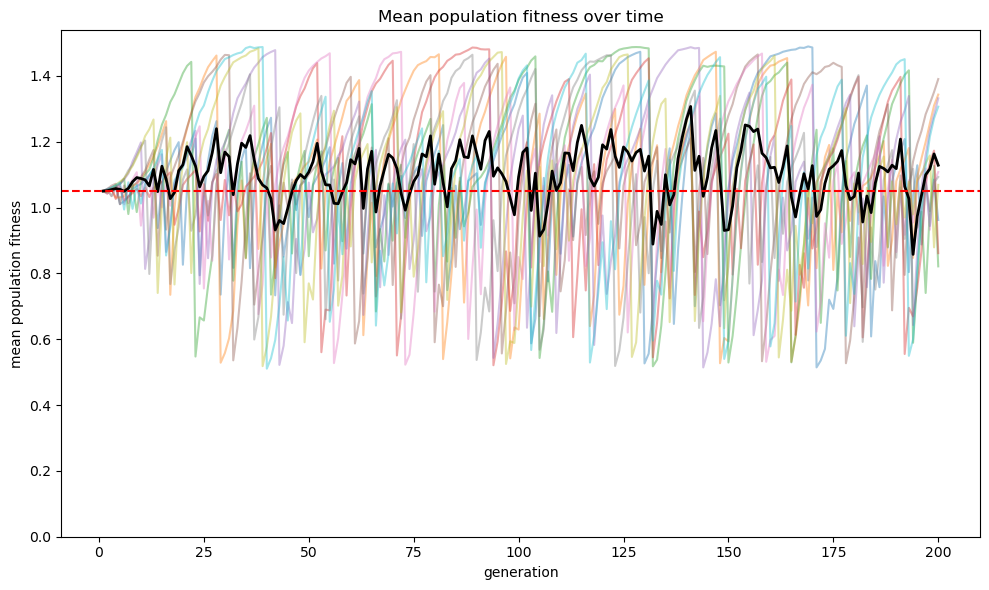

: 

In [ ]:
plot_W(data_model, w=1.0, b=0.5, c=0.9, p=1.0)